In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import math
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 10
### Team Member Names: Arteen, Avi, Momina
### Team Strategy Chosen: Safe 

# **1. Reading in the CSV file and filtering**  
The code in the following section reads in the appropriate CSV file and stores the tickers in a dataframe. Subsequent dataframes are created to store the hist and .info attributes of each ticker for easy access later on. The dataframe is then reformatted and filtered to adhere to the following assignment requirements:
* The portfolio must only contain US listed stocks  
* The portfolio may only include stocks that have an average monthly volume of at least 200,000 shares (calculated based on the time interval of January, 01 to October, 31, 2022)

In [2]:
df = pd.read_csv('Tickers.csv')
print(df.head())

# Since the first ticker in the file is in the first row, it reads as the column
# name in the DF, so this code is to move it into the DF and replaces the column
missing = df.columns[0]
rest = df.rename(columns={missing:"Tickers"})
all_tickers = pd.DataFrame(data=[missing], columns=["Tickers"])
all_tickers = all_tickers.append(rest, ignore_index=True)

all_tickers.head()

   AAPL
0  ABBV
1   ABT
2   ACN
3   AGN
4   AIG


C:\Users\momin\AppData\Local\Temp\ipykernel_13832\3900205445.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_tickers = all_tickers.append(rest, ignore_index=True)


,Tickers
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AGN


In [3]:
# applymap applies the function in the brackets to all the elements in the DF
all_stocks = all_tickers.applymap(yf.Ticker)
all_stocks['Names'] = all_tickers.Tickers

all_stocks.head()

,Tickers,Names
0,yfinance.Ticker object <AAPL>,AAPL
1,yfinance.Ticker object <ABBV>,ABBV
2,yfinance.Ticker object <ABT>,ABT
3,yfinance.Ticker object <ACN>,ACN
4,yfinance.Ticker object <AGN>,AGN


In [4]:
# Start by defining variables (intervals and dates)
interval = "1d"
start = "2022-01-01"
end = "2022-11-01"

# Create a history dataframe which contains tickers  
all_history = pd.DataFrame(data=all_tickers, columns=["Tickers", "History", "History M"])
# Adds prices to the history dataframe
all_history["History"] = [tick.history(start=start, end=end, interval=interval) for tick in all_stocks.Tickers]
all_history["History M"] = [tick.history(start=start, end=end, interval='1mo') for tick in all_stocks.Tickers]

all_history.head()

Got error from yahoo api for ticker AGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AGN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker CELG, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CELG: No data found for this date range, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker RTN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RTN: No data found for this date range, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker AGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AGN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker CELG, Error: {'code': 'Not Found', 'description': 'No data found, s

,Tickers,History,History M
0,AAPL,Open H...,Open H...
1,ABBV,Open H...,Open H...
2,ABT,Open H...,Open H...
3,ACN,Open H...,Open H...
4,AGN,"Empty DataFrame Columns: [Open, High, Low, Clo...","Empty DataFrame Columns: [Open, High, Low, Clo..."


In [5]:
new = pd.DataFrame(columns=['Tickers'])
tick_lst = []

for tick in all_history["Tickers"]:
    # Get the history of the current stock
    hist = all_history[all_history["Tickers"] == tick]['History M'].iloc[0]
    vol = hist.Volume.dropna()  # drop any nans

    x = 0  # Index when running through the history
    while x < len(vol):
        if x == len(vol) - 1: # If you've reached the end of the list, measure against the last month
            # Get the number of business days in that month
            num_days = np.busday_count(vol.index[x].strftime("%Y-%m-%d"), end)
        else: # Measure against the next month 
            # Get the number of business days in that month
            num_days = np.busday_count(vol.index[x].strftime("%Y-%m-%d"), vol.index[x+1].strftime("%Y-%m-%d"))
        
        if num_days < 20:  # If the number of days is less than 20
            vol = vol.drop(vol.index[x])  # Drop the month
            # NOTE we don't increment the index. Since we're removing an element from the DF, incrementing the index would
            # likely cause errors in the future
        else:
            # Increment in index in this case, since the original index doesn't change
            x += 1
    
    # If the mean of the volume of stocks is greater than 200,000 and the value is not NaN
    if vol.mean() >= 200000 and not math.isnan(vol.mean()):
        tick_lst.append(tick)  # Keep this value
    
new['Tickers'] = tick_lst  # Set the DF
all_tickers = new  # Replace the old DF with the new one

# re-create all the previous dataframes around the new one
all_stocks = all_tickers.applymap(yf.Ticker)
all_stocks['Names'] = all_tickers.Tickers

all_history = pd.DataFrame(data=all_tickers, columns=["Tickers", "History"])
all_history["History"] = [tick.history(start=start, end=end, interval=interval) for tick in all_stocks.Tickers]

In [6]:
# Gets the info for all the tickers (necessary for checking the market and for diversification)

# IMPORTANT:
# yfinance is very slow, and getting info may take some time. PLEASE be patient.
# There are print statements to show that the code is still running and functioning properly

info = []  # Put all the info into a list
for tick in all_stocks.Tickers:
    print(tick)
    info.append(tick.info)

all_stocks["Info"] = info  # Store info locally so we don't have to call yfinance again

all_stocks.head()

yfinance.Ticker object <AAPL>
yfinance.Ticker object <ABBV>
yfinance.Ticker object <ABT>
yfinance.Ticker object <ACN>
yfinance.Ticker object <AIG>
yfinance.Ticker object <AMZN>
yfinance.Ticker object <AXP>
yfinance.Ticker object <BA>
yfinance.Ticker object <BAC>
yfinance.Ticker object <BIIB>
yfinance.Ticker object <BK>
yfinance.Ticker object <BLK>
yfinance.Ticker object <BMY>
yfinance.Ticker object <C>
yfinance.Ticker object <CAT>
yfinance.Ticker object <CL>
yfinance.Ticker object <CMCSA>
yfinance.Ticker object <COF>
yfinance.Ticker object <COP>
yfinance.Ticker object <COST>
yfinance.Ticker object <CSCO>
yfinance.Ticker object <CVS>
yfinance.Ticker object <GM>
yfinance.Ticker object <GOOG>
yfinance.Ticker object <JPM>
yfinance.Ticker object <KMI>
yfinance.Ticker object <KO>
yfinance.Ticker object <LLY>
yfinance.Ticker object <LMT>
yfinance.Ticker object <MO>
yfinance.Ticker object <MON>
yfinance.Ticker object <MRK>
yfinance.Ticker object <MS>
yfinance.Ticker object <MSFT>
yfinance.Tick

,Tickers,Names,Info
0,yfinance.Ticker object <AAPL>,AAPL,"{'zip': '95014', 'sector': 'Technology', 'full..."
1,yfinance.Ticker object <ABBV>,ABBV,"{'zip': '60064-6400', 'sector': 'Healthcare', ..."
2,yfinance.Ticker object <ABT>,ABT,"{'zip': '60064-6400', 'sector': 'Healthcare', ..."
3,yfinance.Ticker object <ACN>,ACN,"{'zip': 'D02 P820', 'sector': 'Technology', 'f..."
4,yfinance.Ticker object <AIG>,AIG,"{'zip': '10020', 'sector': 'Financial Services..."


In [7]:
# Create copies (just in case)
new = all_tickers.copy()
new_stocks = all_stocks.copy()
new_hist = all_history.copy()

# Loop through all the tickers
for tick in all_stocks['Names']:
    try:
        market = all_stocks[all_stocks['Names'] == tick]['Info'].iloc[0]['market']  # the market the stock is listed in
        if market != 'us_market':  # Since the stock must be listed in the US
            # Drop that stock from all the copies
            new = new.drop(index=new[new['Tickers'] == tick].index[0])
            new_stocks = new_stocks.drop(index=new_stocks[new_stocks['Names'] == tick].index[0])
            new_hist = new_hist.drop(index=new_hist[new_hist['Tickers'] == tick].index[0])
    # Sometimes we run into a keyerror, so automatically drop those that cause the error
    except KeyError:
        # Drop that stock from all the copies
        new = new.drop(index=new[new['Tickers'] == tick].index[0])
        new_stocks = new_stocks.drop(index=new_stocks[new_stocks['Names'] == tick].index[0])
        new_hist = new_hist.drop(index=new_hist[new_hist['Tickers'] == tick].index[0])

# Replace all the original functions with the filtered ones (new)
all_tickers = new
# Create a new index since the old one will have gaps
all_tickers['Index'] = list(range(0,len(all_tickers.Tickers)))
all_tickers.set_index('Index', inplace=True)

all_stocks = new_stocks
all_stocks['Index'] = list(range(0,len(all_stocks.Names)))
all_stocks.set_index('Index', inplace=True)

all_history = new_hist
all_history['Index'] = list(range(0,len(all_history.Tickers)))
all_history.set_index('Index', inplace=True)

all_tickers.head()

,Tickers
Index,
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AIG


# **2 a. Calculating Standard Deviation**  
Since we are aiming for the safest portfolio, our ultimate goal is to build a portfolio that generates a net return of zero dollars. For this reason, we must select stocks with the least volatility. So naturally, we have calculated the standard deviation for each ticker and utilised it as one of the key determining criteria of our portfolio generator. Specifically, standard deviation helps us weed out any exceptionally explosive stocks, while also allowing us to select stable, reliable stocks. 

In [8]:
# Make a list containing (Ticker, STD) for all the tickers
all_std = [(all_history.Tickers[x], all_history.History[x]["Close"].std()) for x in range(len(all_history["Tickers"]))]

# Sort by the second element in the tuple (STD, not Ticker Name)
all_std.sort(key=lambda x: x[1])

all_std[0:5]  # Show the top 5 lowest STD

[('MON', 0.05536118416804379),
 ('KMI', 0.9731948031980608),
 ('T', 1.5028758895707237),
 ('KO', 2.5066784351678475),
 ('PFE', 3.1542750996376108)]

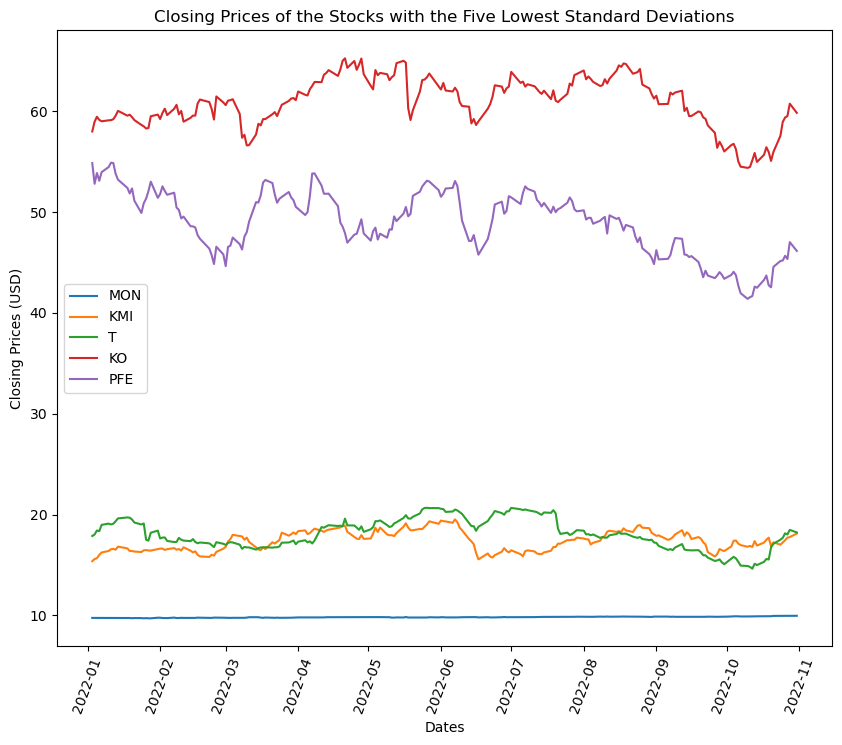

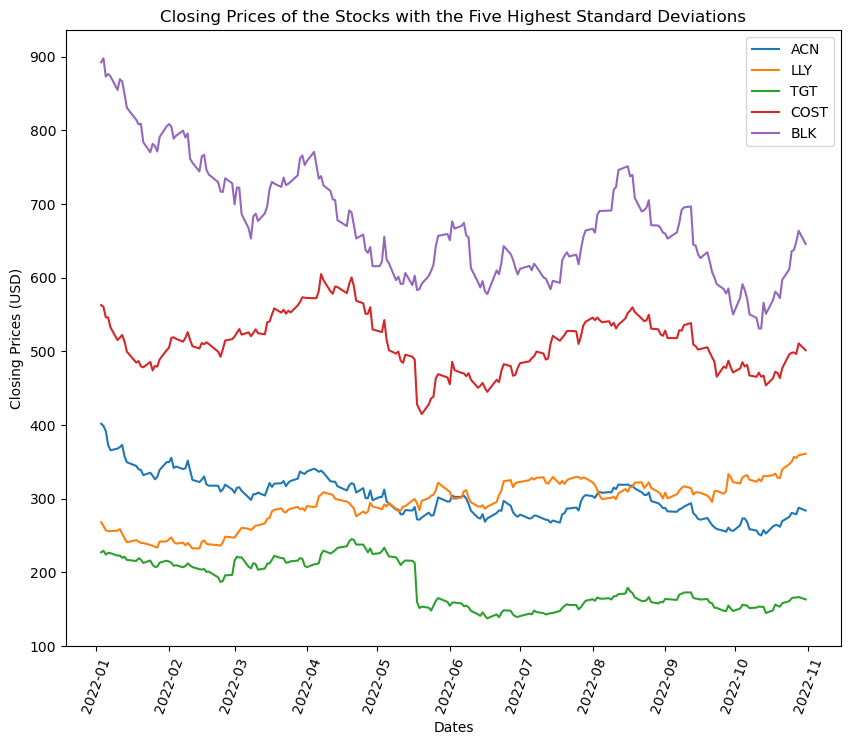

In [9]:
#This function is made to graph data from a list of (Ticker, data).
def graph_data(prices) :

    plt.figure(figsize=(10, 8))

    for p in prices :

        plt.plot(p[1].index, p[1], label=p[0])

    plt.xticks(rotation=70)
    plt.legend(loc='best')

#A list of (Ticker, Closing Price) of the stocks with the 5 lowest standard deviations.
smallest_std_stock_prices = [(all_std[:5][x][0], all_stocks[all_stocks.Names == all_std[:5][x][0]].iloc[0].iloc[0].history(start=start, end=end)["Close"]) for x in range(len(all_std[:5]))]

#Graphing the closing prices for the stocks with the five lowest standard deviations.
graph_data(smallest_std_stock_prices)

plt.title("Closing Prices of the Stocks with the Five Lowest Standard Deviations")
plt.xlabel("Dates")
plt.ylabel("Closing Prices (USD)")

plt.show()
#A list of (Ticker, Closing Price) of the stocks with the 5 lowest standard deviations.
highest_std_stock_prices = [(all_std[len(all_std) - 5:][x][0], all_stocks[all_stocks.Names == all_std[len(all_std) - 5:][x][0]].iloc[0].iloc[0].history(start=start, end=end)["Close"]) for x in range(len(all_std[len(all_std) - 5:]))] 

#Graphing the closing prices for the stocks with the five lowest standard deviations.
graph_data(highest_std_stock_prices)

plt.title("Closing Prices of the Stocks with the Five Highest Standard Deviations")
plt.xlabel("Dates")
plt.ylabel("Closing Prices (USD)")

plt.show()

To further illustrate the importance of including standard deviation in our portfolio strategy, we have graphed the closing prices of the stocks with the 5 lowest, as well as the 5 highest, standard deviations.  
  
Looking at the graphs, it is apparent that the closing prices of the stocks with lower standard deviations generally appear flatter (i.e., less volatile) than the stocks with higher standard deviations. These are exactly the type of stocks we want to favour in our portfolio, since steadier stocks won’t fluctuate as much in value.

# **2 b. Calculating Expected Return**  
Given our goal of obtaining a net return of (near) $0, the expected return of each individual stock is very relevant. To optimize the success of our portfolio, we would need to select stocks that have an expected return that is as close to 0 as possible.  
  
There are a couple ways to calculate expected return. One of our options was to use the following formula:  
> Expected return = (Return A x probability A) + (Return B x probability B) … + (Return i x probability i)

However, accurately predicting all the different scenarios and their respective probabilities for unknown stocks is out of our scope, so this method wasn’t feasible. Hence, we settled for a simpler approach:  
> Expected return = [(Close Price at time 1) - (Close Price at time 2)] / (Close Price at time 1)
  
The timeframe we decided on was January 1, 2022 to November 1, 2022. This timeframe is recent enough so that the market conditions won’t be that different, and it’s also long enough that it gives us a more holistic view of the stock’s trends.  
  
While some nuance is not being considered, the reasoning behind this strategy was as follows: if a stock has not increased or decreased in price significantly since January of this year, chances are it won’t act up now. 

In [10]:
expected_returns = [(all_history.Tickers[x], ((all_history.History[x]['Close'][all_history.History[0]['Close'].index[-1]] - all_history.History[x]['Close'][0])/all_history.History[x]['Close'][0])) for x in range(len(all_history.Tickers))]
expected_returns.sort(key=lambda x:abs(x[1]))
expected_returns[0:5]

[('PM', -0.0012824339483054434),
 ('AIG', 0.01081171948910815),
 ('SO', -0.011959405707222877),
 ('T', 0.019864902528958756),
 ('MON', 0.021538465450971555)]

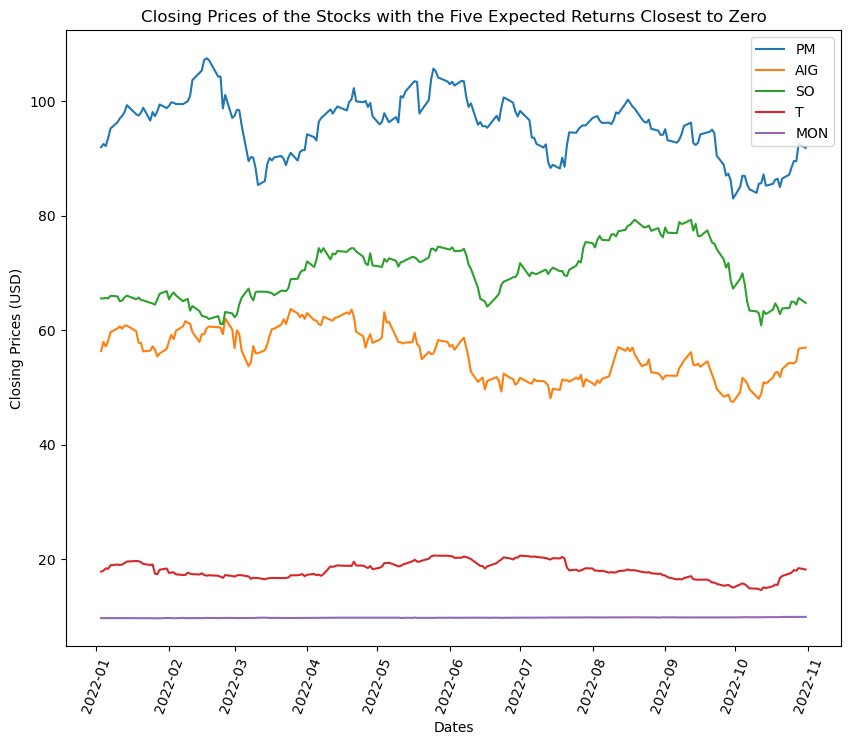

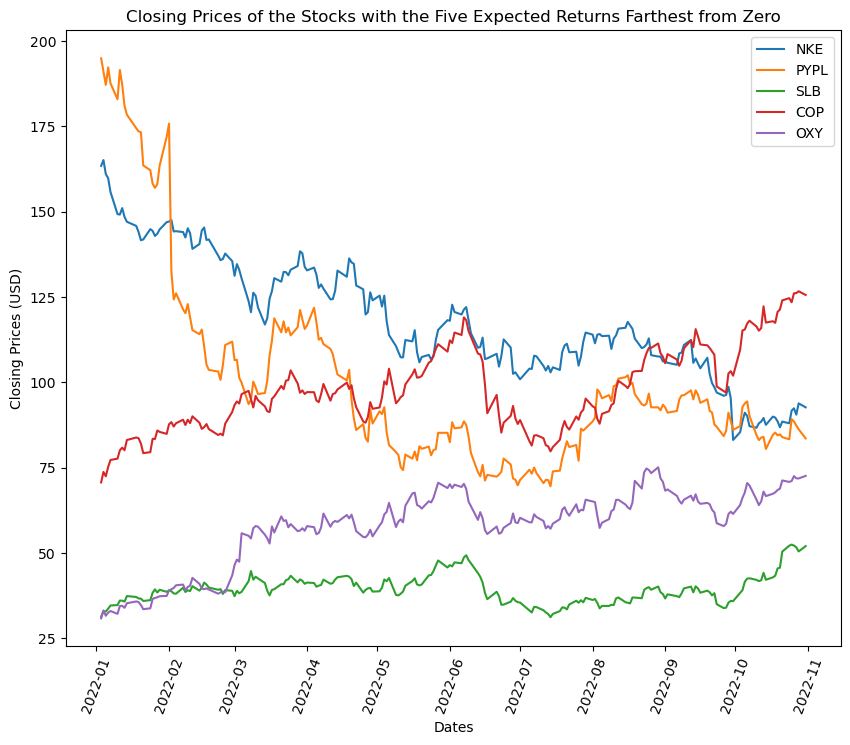

In [11]:
#A list of (Ticker, Closing Price) of the stocks with the 5 expected returns closest to 0.
lowest_expected_return_stock_prices = [(expected_returns[:5][x][0], all_stocks[all_stocks.Names == expected_returns[:5][x][0]].iloc[0].iloc[0].history(start=start, end=end)["Close"]) for x in range(len(expected_returns[:5]))] 

#Graphing the closing prices for the stocks with the five expected returns closest to 0.
graph_data(lowest_expected_return_stock_prices)

plt.title("Closing Prices of the Stocks with the Five Expected Returns Closest to Zero")
plt.xlabel("Dates")
plt.ylabel("Closing Prices (USD)")

plt.show()
#A list of (Ticker, Closing Price) of the stocks with the 5 expected returns farthest from 0.
highest_expected_return_stock_prices = [(expected_returns[len(expected_returns) - 5:][x][0], all_stocks[all_stocks.Names == expected_returns[len(expected_returns) - 5:][x][0]].iloc[0].iloc[0].history(start=start, end=end)["Close"]) for x in range(len(expected_returns[len(expected_returns) - 5:]))] 

#Graphing the closing prices for the stocks with the five expected returns farthest from 0.
graph_data(highest_expected_return_stock_prices)

plt.title("Closing Prices of the Stocks with the Five Expected Returns Farthest from Zero")
plt.xlabel("Dates")
plt.ylabel("Closing Prices (USD)")

plt.show()

We’ve created the above graphs to visualize the difference in the behaviour of stocks with high expected returns, compared to that of those with returns near \\$0. We can concretely see that stocks with higher expected returns tend to have more fluctuations, meaning that their stock price is more volatile. Contrastingly, stocks with expected returns closer to \\$0 tend to be less volatile, and their closing price remains more consistent. As a result, we gave companies with projected returns near \\$0 greater priority than stocks with really high or really low expected returns.


# **2 c. Calculating Beta**  
While standard deviation determines the volatility of a fund according to the disparity of its returns over a period of time, beta compares the risk of a fund with the overall market's volatility. It’s important to take into account a particular stock’s volatility individually (through standard deviation), as well as the stock’s volatility compared to the market – i.e., its beta value. Our code heavily favours stocks with low beta values, as this indicates that the stock is less volatile than the market, and will therefore not fluctuate as much. 

In [12]:
#Calculating a list of containing (Ticker, daily % returns) for all tickers.
daily_returns = [(all_history.Tickers[x], all_history.History[x]["Close"].pct_change()) for x in range(len(all_history.Tickers))]

#Getting the market returns and prices for the S&P 500
def get_market_returns():
    start = '2022-01-01'
    end = '2022-11-01'
    interval = '1d'
    market_index = '^GSPC'

    market_hist = yf.Ticker('^GSPC').history(start=start, end=end, interval=interval)

    market_prices = market_hist['Close']

    market_returns = market_prices.pct_change().dropna()

    return (market_returns, market_prices)

#Calculating the daily returns in a list of (Ticker, Daily market returns).
daily_market_returns, market_prices = get_market_returns()

# Calculating both the market variances for daily returns and five day returns.
market_variance = daily_market_returns.var()

#Calculating the betas in a list of (Ticker, beta) for each daily return.
betas = [(all_history.Tickers[x], (pd.DataFrame({daily_returns[x][0] : daily_returns[x][1],
                                                 '^GSPC' : daily_market_returns}).cov()/market_variance).iat[0, 1]) for x in range(len(all_history.Tickers)) if not math.isnan(all_history.History[x]['Close'].std())]
betas.sort(key=lambda x: x[1])

betas[:5]

[('MON', 0.010760516965011305),
 ('LMT', 0.30742612430177896),
 ('MRK', 0.3124756152124122),
 ('BMY', 0.3146965931723417),
 ('ABBV', 0.3458255225068495)]

In [13]:
#Calculating the monthly returns of the stock with the lowest beta and the stock with the second lowest beta.
low_beta_monthly_returns_1 = all_stocks[all_stocks.Names == betas[0][0]].iloc[0].iloc[0].history(start=start, end=end, interval="1mo")["Close"].pct_change().dropna()
low_beta_monthly_returns_2 = all_stocks[all_stocks.Names == betas[1][0]].iloc[0].iloc[0].history(start=start, end=end, interval="1mo")["Close"].pct_change().dropna()

#Creating a DataFrame to calculate the correlation between the stock with the lowest beta and the stock with the second lowest beta.
correlation_df = pd.DataFrame({betas[1][0] : low_beta_monthly_returns_2,
                               betas[0][0] : low_beta_monthly_returns_1}) 

#Calculation the correlation.
correlation_df.corr()

,LMT,MON
LMT,1.000000,0.579702
MON,0.579702,1.000000


Here, we’ve calculated the correlation between the 2 stocks with the lowest beta values.

We can see from above that there is little correlation between the stocks. This means that as a result of having very little correlation with movements in the market, stocks with low beta will tend to have less correlation with each other as well.

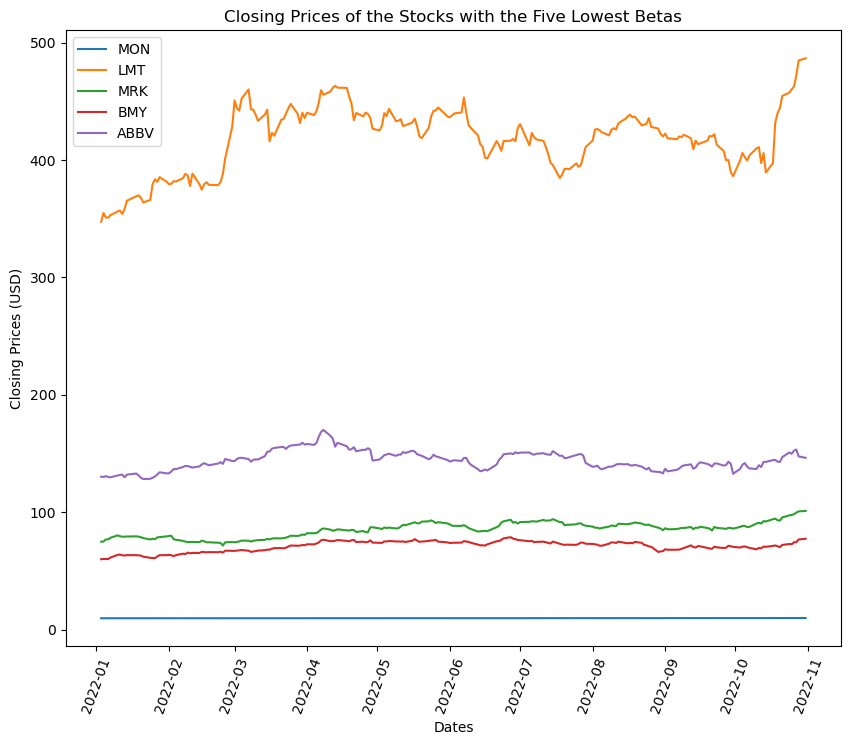

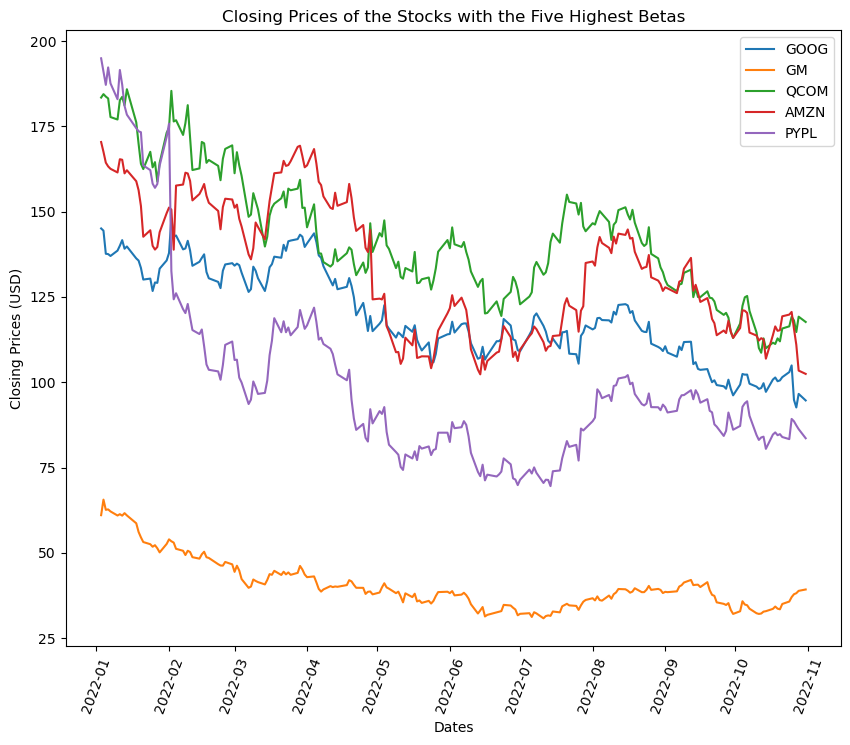

In [14]:
#A list of (Ticker, Closing Price) of the stocks with the 5 lowest betas.
lowest_beta_stock_prices = [(betas[:5][x][0], all_stocks[all_stocks.Names == betas[:5][x][0]].iloc[0].iloc[0].history(start=start, end=end)["Close"]) for x in range(len(betas[:5]))] 

#Graphing the closing prices for the stocks with the five lowest betas.
graph_data(lowest_beta_stock_prices)

plt.title("Closing Prices of the Stocks with the Five Lowest Betas")
plt.xlabel("Dates")
plt.ylabel("Closing Prices (USD)")

plt.show()
#A list of (Ticker, Closing Price) of the stocks with the 5 highest betas.
highest_beta_stock_prices = [(betas[len(betas) - 5:][x][0], all_stocks[all_stocks.Names == betas[len(betas) - 5:][x][0]].iloc[0].iloc[0].history(start=start, end=end)["Close"]) for x in range(len(betas[(len(betas) - 5):]))] 

#Graphing the closing prices for the stocks with the five highest betas.
graph_data(highest_beta_stock_prices)

plt.title("Closing Prices of the Stocks with the Five Highest Betas")
plt.xlabel("Dates")
plt.ylabel("Closing Prices (USD)")

plt.show()

Additionally, by comparing the above two graphs, we can see that stocks with lower betas tend to also experience less fluctuations. This is because a lower beta value indicates that the stock experiences less market risk. Consequently, stocks with lower betas will also be more stable and safe.

Due to these two key reasons,  our program will prefer stocks with lower beta values compared to stocks with higher betas.

# **3. Scoring Each Stock**  
To put our portfolio together, we had to find a way to take into account each factor. However, certain factors were more important than others, which meant we also wanted to be able to control the weight of each factor. There was no existing function that could achieve our desired result, so we created our own function that assigned each stock a score: scoreNumeric. After playing around with different values and some discussion, we decided to weigh the different factors as follows:    
  
Standard deviation: 90  
Expected return: 100  
Beta: 90

In [15]:
# Gives a score to each stock 
def scoreNumeric(sorted_stocks, score_sorted=[], weight=100):
    # Sets a "standard" (the best score, so the rest of the stocks can compare)
    standard = sorted_stocks[0][1]
    # Sorts the list of stocks by name (so it can be matched with score_sorted)
    sorted_stocks.sort()
    if score_sorted != []:
        # Sort this one too so the indexes are the same (sorted by name)
        score_sorted.sort()

    for x in range(len(sorted_stocks)):
        # Finds the new score
        score = abs(weight * (standard / sorted_stocks[x][1]))
        name = sorted_stocks[x][0] 
        stock = (name, score)
        if len(sorted_stocks) != len(score_sorted):
            score_sorted.append(stock)  # If the stock doesn't have a prev score
        else:
            # Add the scores together
            score_sorted[x] = (name, score + score_sorted[x][1])
    
    score_sorted.sort(key=lambda x:x[1], reverse=True)  # Return the list sorted
    
    return score_sorted

In [16]:
# Finds the scores of all eligible stocks based on these attributes
scores = scoreNumeric(all_std, [], 90)
scores = scoreNumeric(expected_returns, scores, 100)
scores = scoreNumeric(betas, scores, 90)
scores[0:5]

[('MON', 185.95415653554647),
 ('PM', 103.34730711354041),
 ('SO', 14.03044192887163),
 ('AIG', 13.995396786971373),
 ('T', 11.697162068749188)]

# **4. Diversification**  
Another component that we wanted our code to incorporate was diversification. 

In essense, diversification aims to minimize risk by investing in different areas that should each react differently to changes in market conditions. Ideally, we would find companies that tend to move in opposite directions and have a negative correlation. To achieve this, we opted to “penalize” stocks if they were from the same sector or country as a stock we had already chosen to add to our portfolio. Simply put, after a stock was selected, the remaining stocks were “re-scored” based on the attributes (namely, sector and country) of the selected stock(s). The 'same sector penalty' is weighted at 10, whereas the 'same country penalty' is weighted at 2. These weightings are based on the assumption that we will be given a variety of stocks from different sectors, but most of these stocks will be American-based. We don't want diversification to override the other factors, so we adjusted the penalty weightings accordingly.   
 
This strategy favoured inter-industry and international investments, and thereby promoted diversification in our portfolio, which simultaneously decreased risk and correlation between our stocks.

In [17]:
# Gets a list of (category, number), where the number and category are based on
# the provided ev (list)
def inPortfolio(ev, category='sector'):
    sets = {}
    for stock in ev:
        try:
            # Add one to the proper category
            sets[all_stocks[all_stocks.Names == stock[0]].Info.iloc[0][category]] += 1
        except KeyError:  # If it doesn't exist, it KeyErrors
            # Create the proper category
            sets[all_stocks[all_stocks.Names == stock[0]].Info.iloc[0][category]] = 1
    
    # Creates the list
    set_list = [(stock, sets[stock]) for stock in sets]
    # Sorts in ascending order
    set_list.sort(key= lambda x:x[1])
    return set_list

# Creates the final portfolio by taking the scores
def createPortfolio(stocks_sorted, sec_weight=10, count_weight=2):
    # Represents the 25 stocks in the portfolio
    portfolio_list = []
    
    for x in range(25):
        # Add the highest rated stock into the portfolio
        portfolio_list.append(stocks_sorted[0])
        # Removes that stock from the list
        stocks_sorted.pop(0)

        # Find the list of industries and countries in the current portfolio
        industries_in_portfolio = inPortfolio(portfolio_list, 'sector')
        countries_in_portfolio = inPortfolio(portfolio_list, 'country')

        # Looking through the rest to adjust scores based on
        # diversification principles 
        for x in range(len(stocks_sorted)):
            name = stocks_sorted[x][0]
            score = stocks_sorted[x][1]
  
            for pair in industries_in_portfolio:
                # if the current stocks sector is already in the portfolio
                if all_stocks[all_stocks.Names == name].Info.iloc[0]['sector'] == pair[0]:
                    # Apply a score penalty based on how many 
                    # stocks of that sector are already in the portfolio
                    stocks_sorted[x] = (name, score - (sec_weight * pair[1]))
            
            for pair in countries_in_portfolio:
                # if the current stocks country is already in the portfolio
                if all_stocks[all_stocks.Names == name].Info.iloc[0]['country'] == pair[0]:
                    # Apply a score penalty based on how many 
                    # stocks of that country are already in the portfolio
                    stocks_sorted[x] = (name, score - (count_weight * pair[1]))
        
        # Sort the list each time to bring the best stock to the top
        stocks_sorted.sort(key=lambda x:x[1], reverse=True)
    
    # Return a list of the best 25 tickers (names)
    portfolio_list = [name[0] for name in portfolio_list]
    return portfolio_list

# list of the best tickers
tickers = createPortfolio(scores.copy())

# **5. Creating the Portfolio**  
In this last chunk of code, we are putting together the portfolio in a dataframe with the appropriate columns, as well as outputting the dataframe to a CSV file, as required by the specifications of the assignment.

In [18]:
# Date for the price is November 25th 2022
date = '2022-11-25'  # '2022-01-01'
date_1 = '2022-11-26'  # '2022-11-01'

# Weights for each stock is 4%
weights_for_all = 0.04
price = 500000

# Creates the final portfolio with the requested columns
Portfolio_Final = pd.DataFrame(columns=['Ticker', 'Price', 'Shares', 'Value', 'Weight', 'Index'])
# Tickers
Portfolio_Final['Ticker'] = tickers
# Prices based on the close price of Date (November 25th 2022)
Portfolio_Final['Price'] = [all_stocks[all_stocks.Names == tick].iloc[0].iloc[0].history(start=date, end=date_1)["Close"][0] for tick in tickers]
# Shares is the total budget (500000 * weight) divided by the price
Portfolio_Final['Shares'] = price * weights_for_all / Portfolio_Final['Price']
# Value is the price pre share times the number of shares
Portfolio_Final['Value'] = Portfolio_Final['Shares'] * Portfolio_Final['Price']
# All weights are 4%, so create a list of 4s
Portfolio_Final['Weight'] = [weights_for_all * 100 for x in range(25)]
# Create the new index (1, 25)
Portfolio_Final['Index'] = list(range(1,26))
Portfolio_Final.set_index('Index', inplace=True)

Portfolio_Final.head()

,Ticker,Price,Shares,Value,Weight
Index,,,,,
1,MON,10.010000,1998.001952,20000.0,4.0
2,PM,98.250000,203.562341,20000.0,4.0
3,SO,66.910004,298.908966,20000.0,4.0
4,AIG,61.080002,327.439414,20000.0,4.0
5,ACN,296.399994,67.476385,20000.0,4.0


In [19]:
# Stocks_Final is Portfolio_Final but with less columns
Stocks_Final = Portfolio_Final.drop(['Price', 'Value', 'Weight'], axis=1)
# Send the dataframe to a csv file (without index)
Stocks_Final.to_csv('Stocks_Group_10.csv', index=True)
Stocks_Final

,Ticker,Shares
Index,,
1,MON,1998.001952
2,PM,203.562341
3,SO,298.908966
4,AIG,327.439414
5,ACN,67.476385
6,T,1046.025059
7,MO,447.027252
8,KO,319.030155
9,KMI,1073.537354


In [20]:
# Print out the requested information
print("The total weight of the portfolio is: %.2f" % Portfolio_Final.Weight.sum())
print("The total price of the portfolio at the start date is: $%.2f" % (Portfolio_Final.Price * Portfolio_Final.Shares).sum())
Portfolio_Final

The total weight of the portfolio is: 100.00
The total price of the portfolio at the start date is: $500000.00


,Ticker,Price,Shares,Value,Weight
Index,,,,,
1,MON,10.010000,1998.001952,20000.0,4.0
2,PM,98.250000,203.562341,20000.0,4.0
3,SO,66.910004,298.908966,20000.0,4.0
4,AIG,61.080002,327.439414,20000.0,4.0
5,ACN,296.399994,67.476385,20000.0,4.0
6,T,19.120001,1046.025059,20000.0,4.0
7,MO,44.740002,447.027252,20000.0,4.0
8,KO,62.689999,319.030155,20000.0,4.0
9,KMI,18.629999,1073.537354,20000.0,4.0


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Arteen Mirzaei

Momina Butt

Avi Dave